In [1]:
import sys
import operator
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt

datadir = '/home/ignacio/myprojects/jcloud/'

In [2]:
df_raw = pd.read_csv(f'{datadir}/jobcloud_interview_challenge.csv')

# Get some basic data information
print('dataframe size {}'.format(df_raw.shape))
print('dataframe columns {}'.format(df_raw.columns))
print('dataframe dtypes {}'.format(df_raw.dtypes))
print('dataframe size {0:.3f}MB'.format(sys.getsizeof(df_raw)/1024/1024))
print('dataframe memory usage (Bytes) per column:')
print(df_raw.memory_usage())

# Are there any NAN values?
print('Any nan values?')
print(df_raw.isnull().sum())

# Transform 'cal_dt' to np.int32. Not really an issue here since data small enough to keep in memory
df_raw['cal_dt_int32'] = df_raw['cal_dt'].apply(lambda x: x.replace('-','')).astype(np.int32)

# Check memory usage
print('Updated memory usage:')
print(df_raw.memory_usage())

# Add new column with day of week
df_raw['dayofweek'] = df_raw.cal_dt.astype('datetime64[D]').apply(lambda x: x.isoweekday())

dataframe size (457136, 5)
dataframe columns Index(['cal_dt', 'user_id', 'job_id', 'language', 'source'], dtype='object')
dataframe dtypes cal_dt      object
user_id     object
job_id       int64
language    object
source      object
dtype: object
dataframe size 129.201MB
dataframe memory usage (Bytes) per column:
Index            80
cal_dt      3657088
user_id     3657088
job_id      3657088
language    3657088
source      3657088
dtype: int64
Any nan values?
cal_dt      0
user_id     0
job_id      0
language    0
source      0
dtype: int64
Updated memory usage:
Index                80
cal_dt          3657088
user_id         3657088
job_id          3657088
language        3657088
source          3657088
cal_dt_int32    1828544
dtype: int64


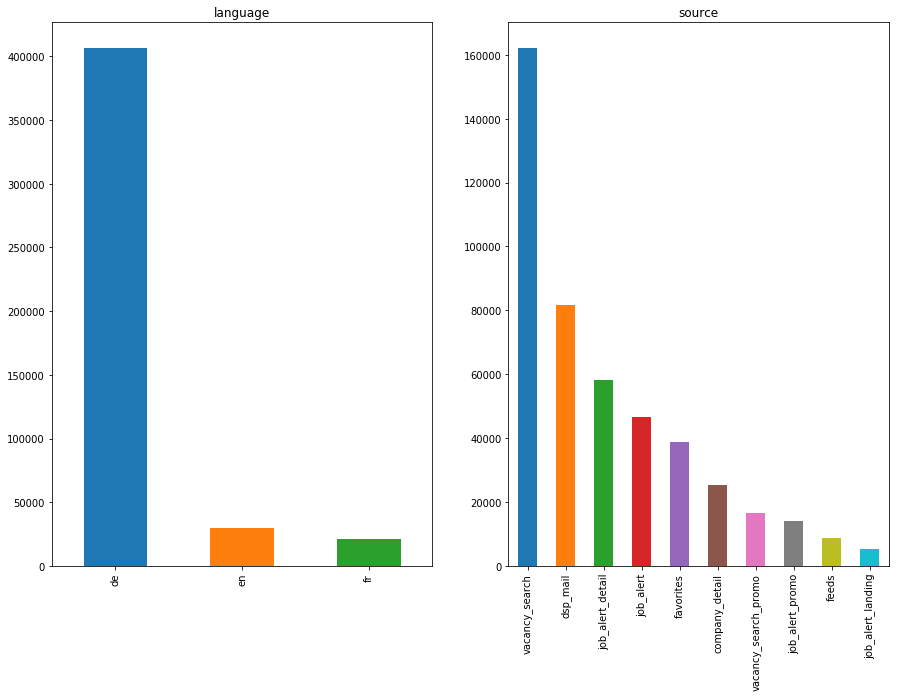

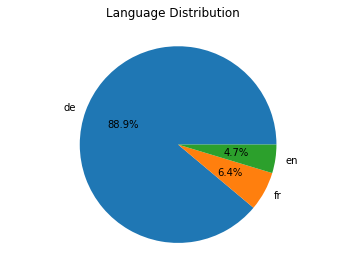

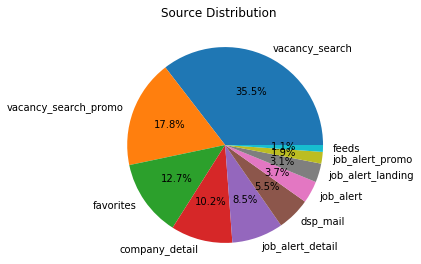

In [3]:
# Some basic plots
fig, axs = plt.subplots(1,2, figsize=(15, 10))
df_raw['language'].value_counts().plot.bar(subplots=True, ax=axs[0])
df_raw['source'].value_counts().plot.bar(subplots=True, ax=axs[1])

fig, axs = plt.subplots(1,1)
axs.pie(df_raw.language.value_counts(normalize=True), labels=df_raw.language.unique(), autopct='%1.1f%%')
axs.axis('equal')
fig.suptitle('Language Distribution')
#fig.savefig('language_pie.png')

fig, axs = plt.subplots(1,1)
axs.pie(df_raw.source.value_counts(normalize=True), labels=df_raw.source.unique(), autopct='%1.1f%%')
axs.axis('equal')
fig.suptitle('Source Distribution')
fig.savefig('source_pie.png')
fig.savefig('lang_source_bars.png')
#plt.close()

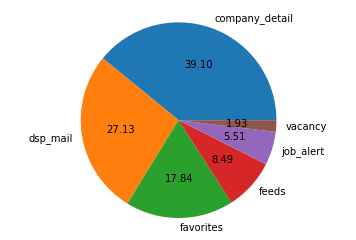

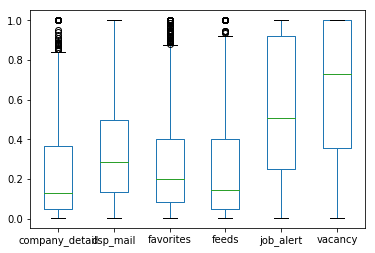

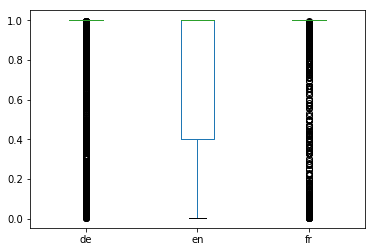

In [5]:
# Create coarser source categories
source_dict = {j: 'job_alert' for j in df_raw.source.unique() if 'alert' in j}
source_dict.update({j: 'vacancy' for j in df_raw.source.unique() if 'vacancy' in j})
source_dict.update({j: j for j in df_raw.source.unique() if 'vacancy' not in j and 'alert' not in j})
df_raw['source_coarse'] = df_raw.source.map(source_dict)
fig, axs = plt.subplots(1,1)
axs.pie(df_raw.source_coarse.value_counts(normalize=True), labels=np.unique(list(source_dict.values())), autopct='%.2f')
axs.axis('equal')
fig.savefig('source_coarse_pie.png')

# Do users stick to the same source category?
df_raw.groupby('user_id')['source_coarse'].value_counts(normalize=True).unstack().plot.box()

# Do users stick to the same language?
df_raw.groupby('user_id')['language'].value_counts(normalize=True).unstack().plot.box()

In [6]:
dates = sorted(df_raw.cal_dt_int32.unique())
#df_raw.groupby(['cal_dt'])['user_id'].value_counts().unstack().mean(1).plot(ax=axs)
clicks_de = df_raw.loc[df_raw.language=='de'].groupby(['cal_dt', 'dayofweek'])['user_id'].value_counts().unstack()
clicks_de.lang = 'DE'
clicks_fr = df_raw.loc[df_raw.language=='fr'].groupby(['cal_dt', 'dayofweek'])['user_id'].value_counts().unstack()
clicks_fr.lang = 'FR'
clicks_en = df_raw.loc[df_raw.language=='en'].groupby(['cal_dt', 'dayofweek'])['user_id'].value_counts().unstack()
clicks_en.lang = 'EN'

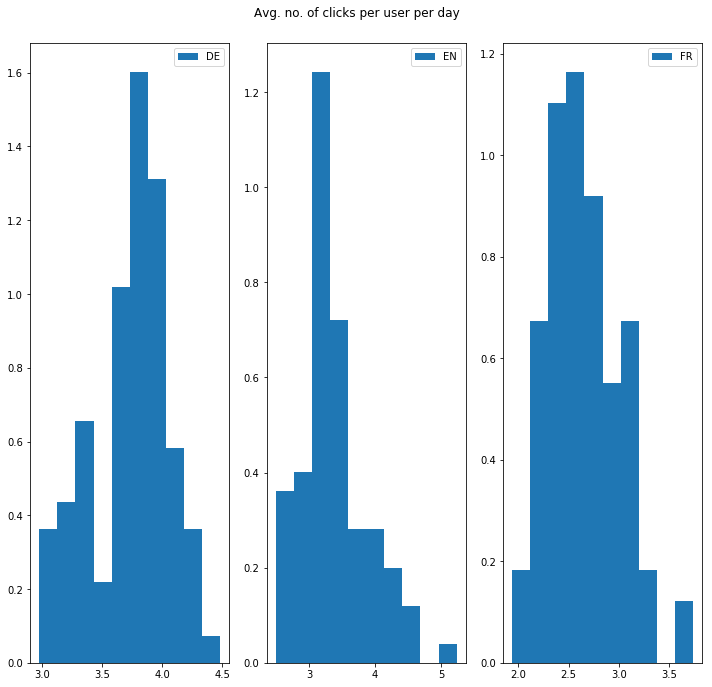

In [7]:
fig, axs = plt.subplots(1,3, figsize=(10,10))
for idx, clicks in enumerate([clicks_de, clicks_en, clicks_fr]):
    axs[idx].hist(clicks.mean(1), density=True, label=clicks.lang)
    #axs[idx].text(2, 5.4, 'mean {0:.3f}'.format(clicks.mean(1).mean()))
    #axs[idx].text(2, 5.32, 'std {0:.3f}'.format(clicks.mean(1).std()))
    #axs[idx].text(2, 5.24, 'max {0:.3f} @ {1}'.format(clicks.mean(1).max(), clicks.mean(1).idxmax()))
    axs[idx].legend()
fig.suptitle("Avg. no. of clicks per user per day")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('hist_avgclicks.png')

In [17]:
# Run a quick KS 2 sample test to check whether language sample are drawn from same distribution
ks2s_defr = ks_2samp(clicks_de.mean(1), clicks_fr.mean(1))
ks2s_deen = ks_2samp(clicks_de.mean(1), clicks_en.mean(1))
ks2s_fren = ks_2samp(clicks_fr.mean(1), clicks_en.mean(1))
print('KS 2 sample: DE vs FR statistic {0:.6f}, p-value {0:.6f}'.format(ks2s_defr[0], ks2s_defr[1]))
print('KS 2 sample: DE vs EN statistic {0:.6f}, p-value {0:.6f}'.format(ks2s_deen[0], ks2s_deen[1]))
print('KS 2 sample: FR vs EN statistic {0:.6f}, p-value {0:.6f}'.format(ks2s_fren[0], ks2s_fren[1]))
# p>~0.5: Samples seem to have same underlying distribution

KS 2 sample: DE vs FR statistic 0.868132, p-value 0.868132
KS 2 sample: DE vs EN statistic 0.494505, p-value 0.494505
KS 2 sample: FR vs EN statistic 0.659341, p-value 0.659341


In [18]:
def do_ts_plots(inputdata, mode='notna().sum()', ylabel='No. active users', pngfile=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    for idx, clicks in enumerate(inputdata):
        lang = clicks.lang
        for m in mode.split('.'):
            farg = m[m.find('(')+1:m.find(')')]
            if len(farg) == 0:
                clicks = getattr(clicks, m[:m.find('(')])()
            else:
                clicks = getattr(clicks, m[:m.find('(')])(int(farg))
        clicks = clicks.reset_index(1).drop('dayofweek', axis=1)
        axs[idx].plot(clicks, label=lang)
        low_, high_ = axs[idx].get_ylim()
        axs[idx].set_ylim(low_, high_*1.1)
        axs[idx].text(2, high_*1.05, 'mean {0:.3f}'.format(clicks.mean().values[0]))
        axs[idx].text(2, high_*1.02, 'std {0:.3f}'.format(clicks.std().values[0]))
        if 'mean' in mode:
            axs[idx].text(2, high_*0.99, 'max {0:.3f} @ {1}'.format(clicks.max().values[0], clicks.idxmax().values[0]))
        axs[idx].set_ylabel(ylabel)
        axs[idx].set_xticks(range(5,90,10))
        axs[idx].set_xticklabels(operator.itemgetter(*range(5,90,10))(dates))
        axs[idx].legend()
        for ticks in axs[idx].get_xticklabels():
            ticks.set_rotation(90)
    if pngfile is not None:
        fig.savefig(pngfile)
    return fig, axs

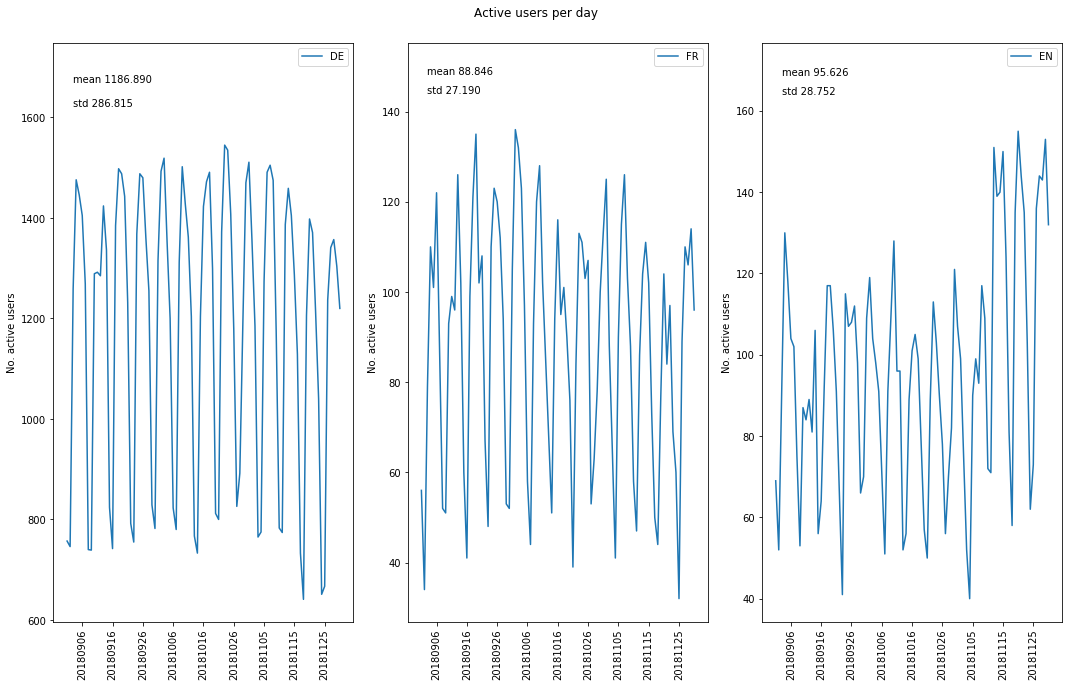

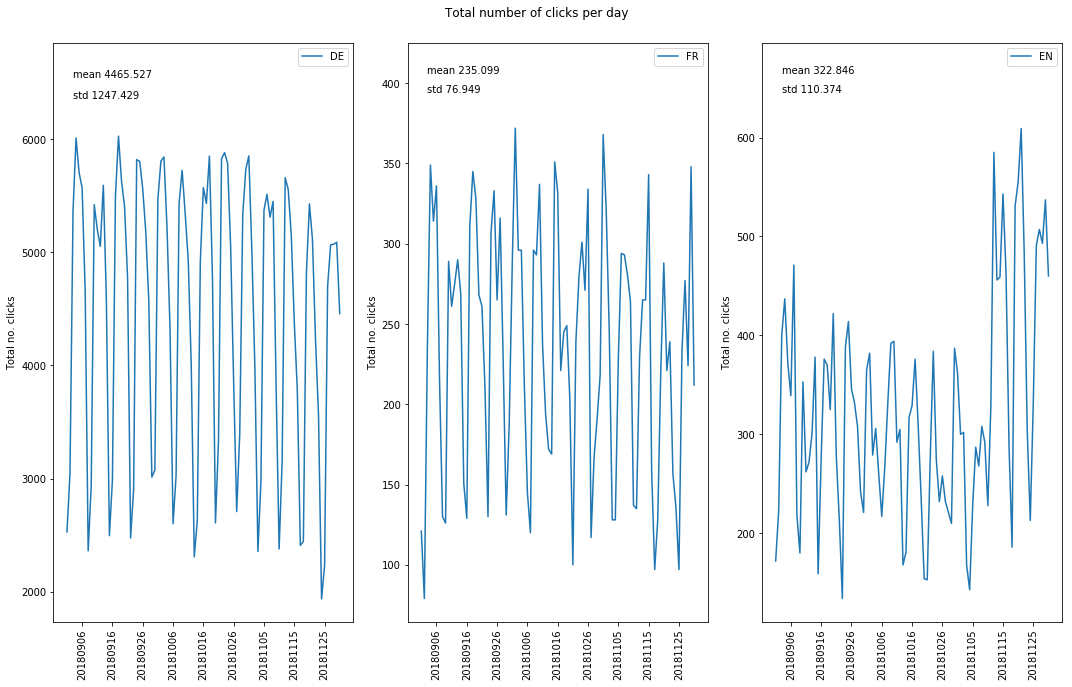

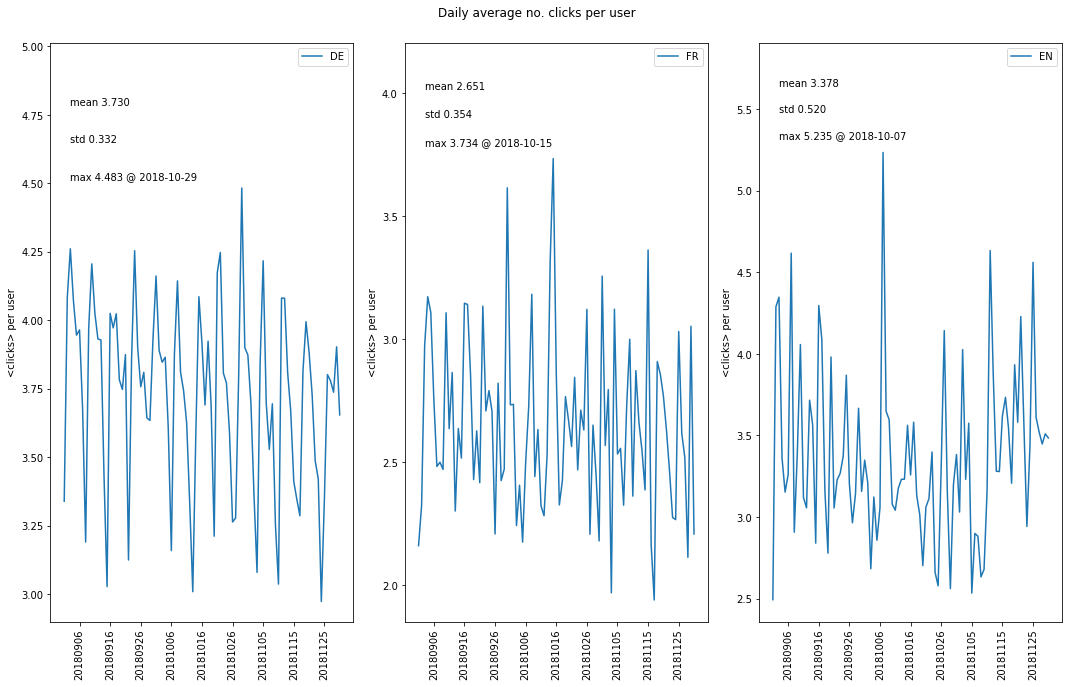

In [19]:
fig1, axs1 = do_ts_plots([clicks_de, clicks_fr, clicks_en], 'notna().sum(1)', ylabel='No. active users')
fig1.suptitle("Active users per day")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig1.savefig('ts_activeusers.png')

fig1, axs1 = do_ts_plots([clicks_de, clicks_fr, clicks_en], 'sum(1)', ylabel='Total no. clicks')
fig1.suptitle("Total number of clicks per day")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig1.savefig('ts_sumclicks.png')

fig1, axs1 = do_ts_plots([clicks_de, clicks_fr, clicks_en], 'mean(1)', ylabel='<clicks> per user')
fig1.suptitle("Daily average no. clicks per user")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig1.savefig('ts_avgclicks.png')

/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'DE - ACF and PACF')

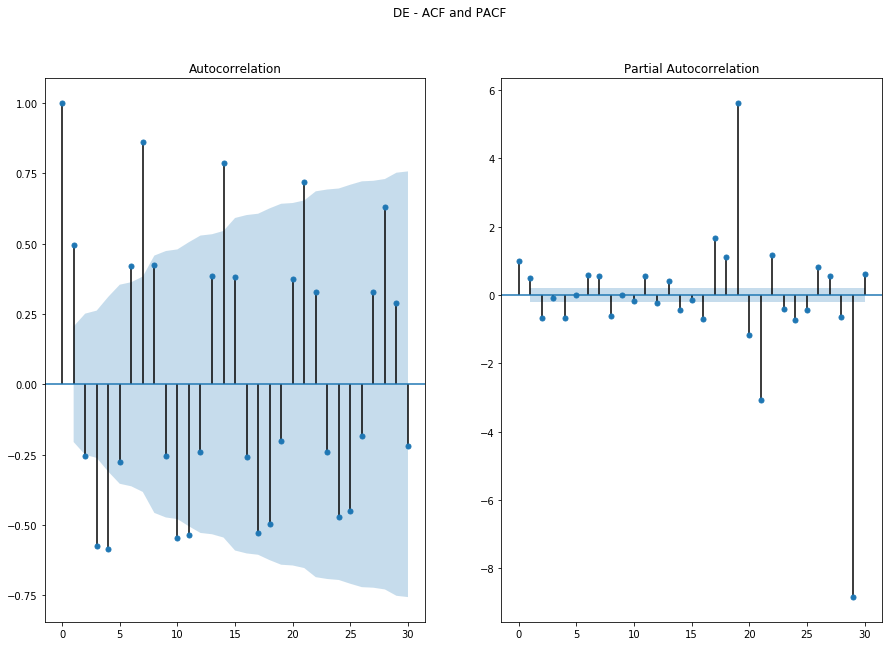

In [20]:
# Look at ACF and PACF in order to estimate ARIMA parameters for No. of click prediction
fig, axs = plt.subplots(1,2, figsize=(15,10))
_ = plot_acf(clicks_de.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[0], lags=30)
_ = plot_pacf(clicks_de.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[1], lags=30)
fig.suptitle('DE - ACF and PACF')

Text(0.5, 0.98, 'EN - ACF and PACF')

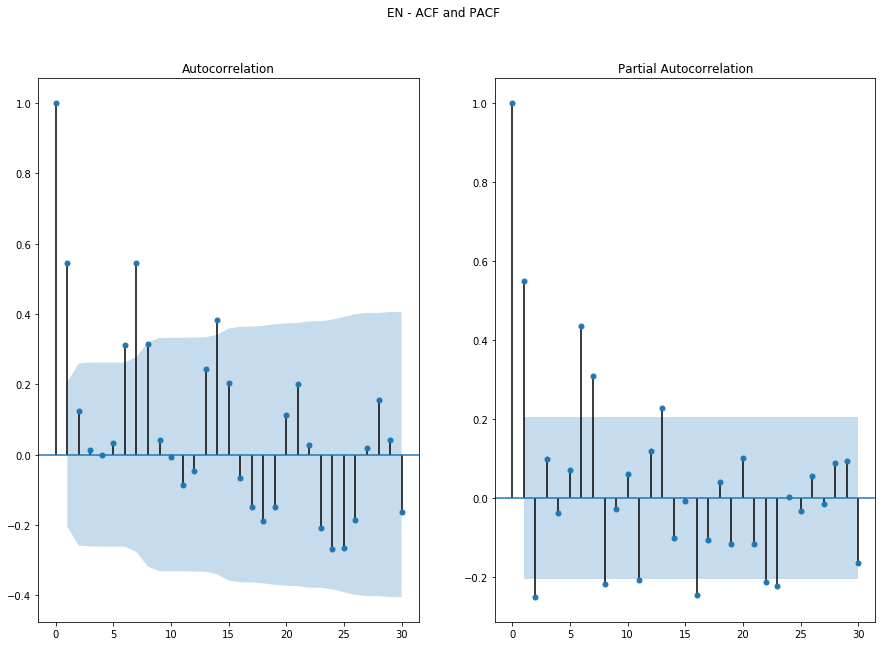

In [23]:
fig, axs = plt.subplots(1,2, figsize=(15,10))
_ = plot_acf(clicks_en.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[0], lags=30)
_ = plot_pacf(clicks_en.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[1], lags=30)
fig.suptitle('EN - ACF and PACF')

Text(0.5, 0.98, 'FR - ACF and PACF')

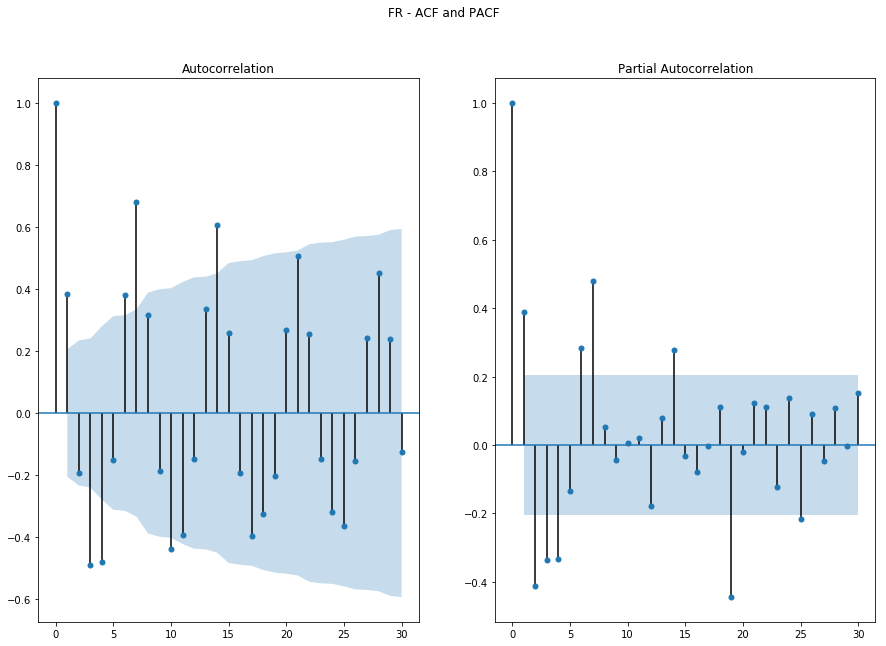

In [24]:
fig, axs = plt.subplots(1,2, figsize=(15,10))
_ = plot_acf(clicks_fr.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[0], lags=30)
_ = plot_pacf(clicks_fr.reset_index(1).drop('dayofweek', axis=1).sum(1).values, ax=axs[1], lags=30)
fig.suptitle('FR - ACF and PACF')

Text(0.5, 0.98, 'Daily pct. change clicks')

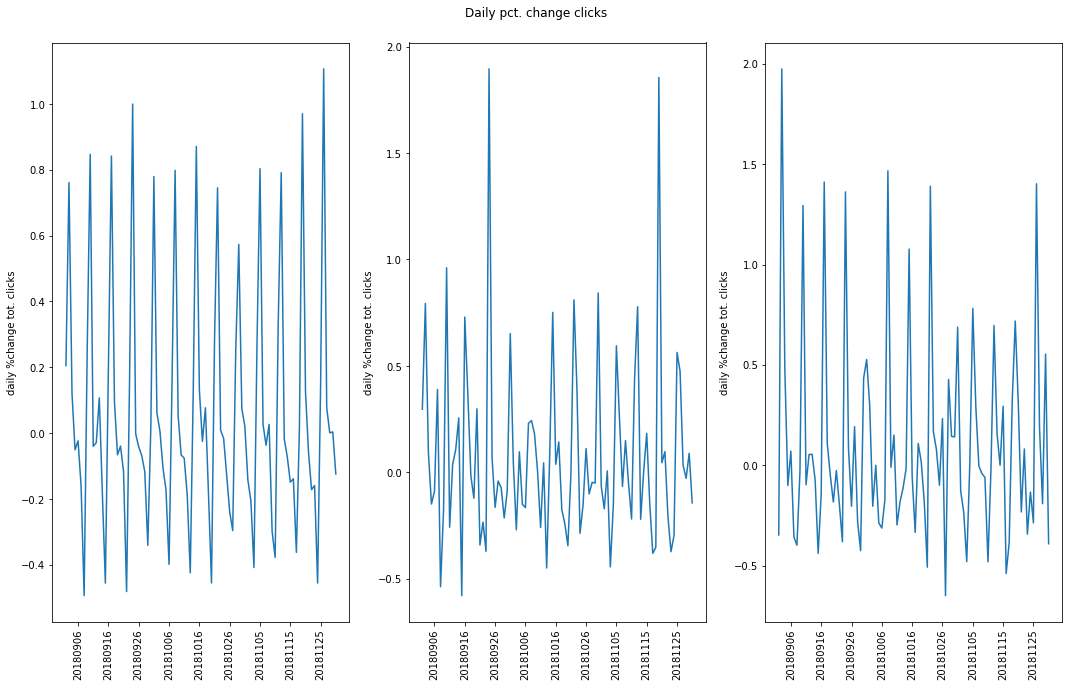

In [25]:
# Relative change
rel_de = (clicks_de.sum(1).diff(1)/clicks_de.sum(1).shift(1))
rel_fr = (clicks_fr.sum(1).diff(1)/clicks_fr.sum(1).shift(1))
rel_en = (clicks_en.sum(1).diff(1)/clicks_en.sum(1).shift(1))

fig, axs = plt.subplots(1,3, figsize=(15,10))
for idx, reldata in enumerate([rel_de, rel_en, rel_fr]):
    axs[idx].plot(reldata.reset_index(1).drop('dayofweek', axis=1))
    axs[idx].set_xticks(range(5,90,10))
    axs[idx].set_xticklabels(operator.itemgetter(*range(5,90,10))(dates))
    axs[idx].set_ylabel('daily %change tot. clicks')
    for ticks in axs[idx].get_xticklabels():
        ticks.set_rotation(90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Daily pct. change clicks')

#fig.savefig('rel_totalclicks.png')

In [26]:
# Is the relative change stationary?
adf_de = adfuller(rel_de.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
kpss_de = kpss(rel_de.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
print(' -- DE -- ')
print('DE rel. change: adf statistic {0:.6f}, p-value {1:.6f}'.format(adf_de[0], adf_de[1]))
print('DE rel. change: kpss statistic {0:.6f}, p-value {1:.6f}'.format(kpss_de[0], kpss_de[1]))
adf_fr = adfuller(rel_fr.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
kpss_fr = kpss(rel_fr.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
print(' -- FR -- ')
print('FR rel. change: adf statistic {0:.6f}, p-value {1:.6f}'.format(adf_fr[0], adf_fr[1]))
print('FR rel. change: kpss statistic {0:.6f}, p-value {1:.6f}'.format(kpss_fr[0], kpss_fr[1]))
adf_en = adfuller(rel_en.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
kpss_en = kpss(rel_en.reset_index(1).drop('dayofweek', axis=1).dropna().values.squeeze())
print(' -- EN -- ')
print('EN rel. change: adf statistic {0:.6f}, p-value {1:.6f}'.format(adf_en[0], adf_en[1]))
print('EN rel. change: kpss statistic {0:.6f}, p-value {1:.6f}'.format(kpss_en[0], kpss_en[1]))
# ADF says we have no unit-root at least at 5% level (see DE results) and KPSS cannot be rejected at more than 10%

 -- DE -- 
DE rel. change: adf statistic -3.253503, p-value 0.017089
DE rel. change: kpss statistic 0.161257, p-value 0.100000
 -- FR -- 
FR rel. change: adf statistic -14.305372, p-value 0.000000
FR rel. change: kpss statistic 0.227188, p-value 0.100000
 -- EN -- 
EN rel. change: adf statistic -9.032803, p-value 0.000000
EN rel. change: kpss statistic 0.138968, p-value 0.100000


/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'DE - ACF and PACF')

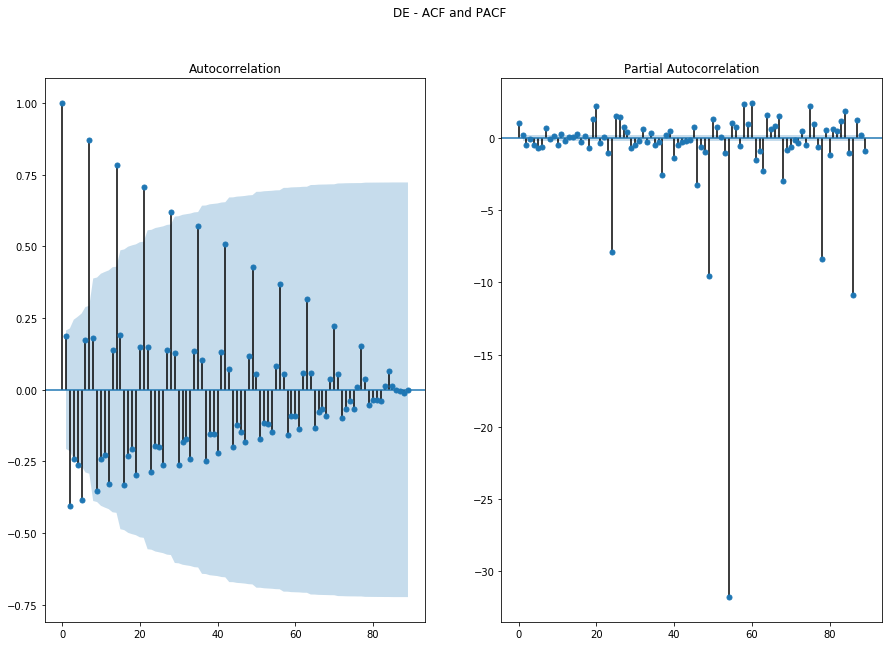

In [27]:
fig, axs = plt.subplots(1,2, figsize=(15,10))
_=plot_acf(rel_de.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[0])
_=plot_pacf(rel_de.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[1])
fig.suptitle('DE - ACF and PACF')

/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'FR - ACF and PACF')

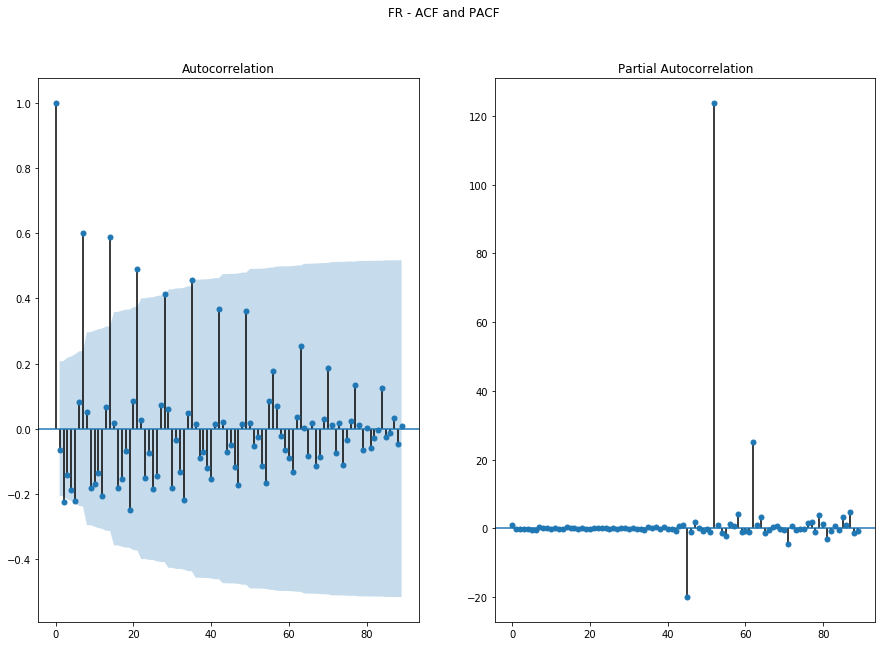

In [28]:
fig, axs = plt.subplots(1,2, figsize=(15,10))
_=plot_acf(rel_fr.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[0])
_=plot_pacf(rel_fr.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[1])
fig.suptitle('FR - ACF and PACF')

/home/ignacio/myutils/anaconda3/envs/the_ignacio_project/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'EN - ACF and PACF')

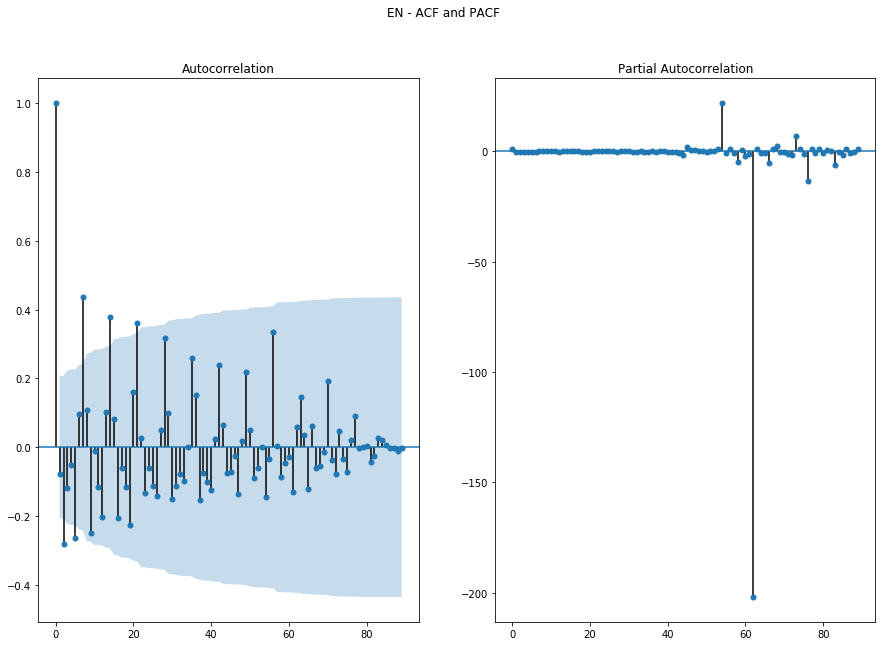

In [29]:
fig, axs = plt.subplots(1,2, figsize=(15,10))
_=plot_acf(rel_en.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[0])
_=plot_pacf(rel_en.reset_index(1).drop('dayofweek', axis=1).dropna().values, ax=axs[1])
fig.suptitle('EN - ACF and PACF')

Text(0.5, 0.98, 'Tot. clicks EN - weekday')

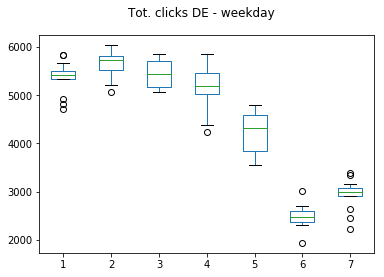

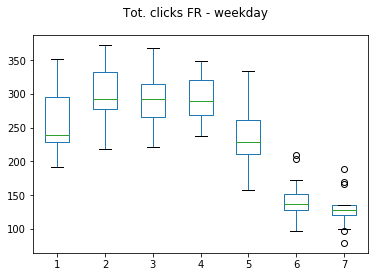

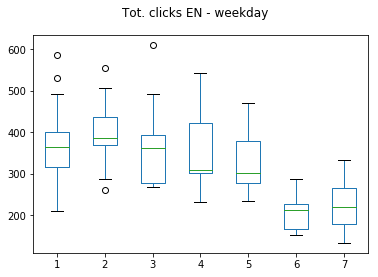

In [30]:
# Boxplot of clicks per day of week
fig, axs = plt.subplots(1,1)
clicks_de.sum(1).unstack().plot.box(ax=axs)
fig.suptitle('Tot. clicks DE - weekday')
fig, axs = plt.subplots(1,1)
clicks_fr.sum(1).unstack().plot.box(ax=axs)
fig.suptitle('Tot. clicks FR - weekday')
fig, axs = plt.subplots(1,1)
clicks_en.sum(1).unstack().plot.box(ax=axs)
fig.suptitle('Tot. clicks EN - weekday')

Text(0.5, 0.98, 'Industry distribution')

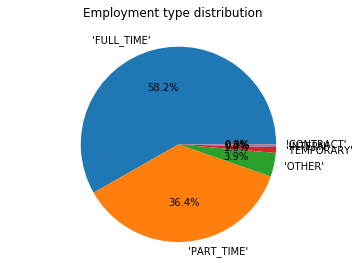

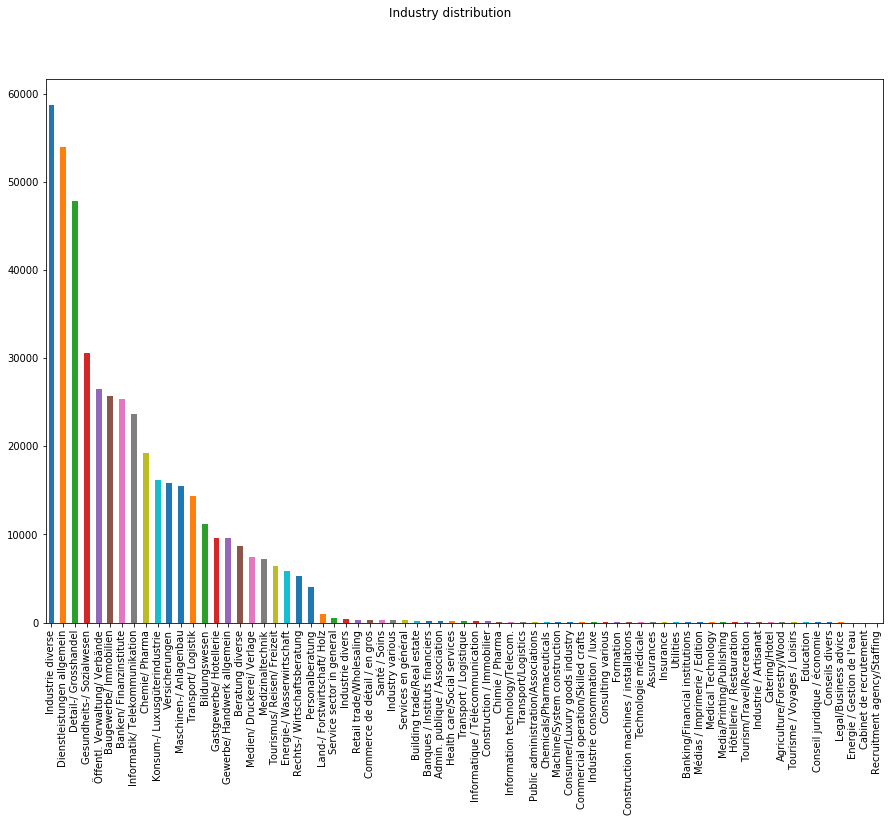

In [32]:
# Add info from scraped data
# csv files collected from URL request to 'https://www.jobs.ch/de/stellenangebote/detail/<jobid>/'
# using collectjobinfo.py.
jobinfo = pd.read_csv('jobinfo.csv.gz', encoding='utf-8', lineterminator='\n')
# Transform employment type, keep only first entry for simplicity
jobinfo['employmentType'] = jobinfo.employmentType.fillna('NA').apply(lambda x: x[1:-1].split(',')[0])
df_merged = df_raw.merge(jobinfo[['jobid', 'industry', 'employmentType']], left_on='job_id', right_on='jobid')

# Job type pie chart
fig, axs = plt.subplots(1,1)
axs.pie(df_merged.employmentType.value_counts(normalize=True), labels=df_merged.employmentType.unique(), autopct='%1.1f%%')
axs.axis('equal')
fig.suptitle('Employment type distribution')
#fig.savefig('employment_type.png')

fig, axs = plt.subplots(1,1, figsize=(15,10))
df_merged.industry.value_counts().plot.bar(ax=axs)
fig.suptitle("Industry distribution")